# Titanic - Machine Learning Project (UT)
---

In [1]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

---

## Plan

1) **Input Data** - for importing our train and test data set.

2) **Data Exploration** - for exploring our train data set 

3) **Feature Engineering** - for merging and removing columns

---

### Input Data

In [2]:
os.listdir('inputs/')

['test.csv', 'train.csv']

In [3]:
train_df = pd.read_csv("./inputs/train.csv")
test_df = pd.read_csv("./inputs/test.csv")

In [4]:
data_list = [train_df, test_df]

In [5]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [7]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


---

### Data Exploration

In [8]:
print(f"Train data is {train_df.shape[0]} rows, with {train_df.shape[1]} columns")
print(f"Test data is {test_df.shape[0]} rows, with {test_df.shape[1]} columns")

Train data is 891 rows, with 12 columns
Test data is 418 rows, with 11 columns


In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [10]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [11]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [12]:
numeric_columns = train_df[['Age','SibSp','Parch','Fare']]
categorical_columns = train_df[['Survived','Pclass','Sex','Ticket','Cabin','Embarked']]

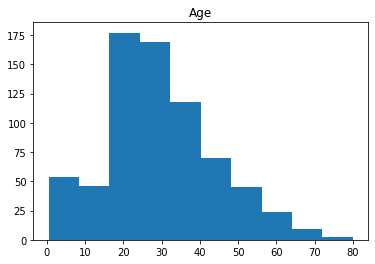

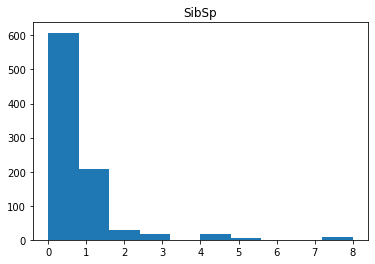

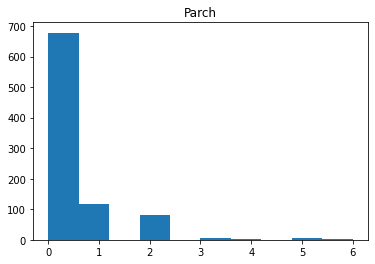

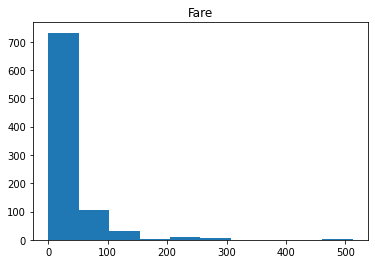

In [13]:
for i in numeric_columns.columns:
    plt.hist(numeric_columns[i])
    plt.title(i)
    plt.show()

In [14]:
pd.pivot_table(train_df, index = 'Survived', values = ['Age','SibSp','Parch','Fare'])

,Age,Fare,Parch,SibSp
Survived,,,,
0,30.626179,22.117887,0.329690,0.553734
1,28.343690,48.395408,0.464912,0.473684


In [15]:
pd.pivot_table(train_df, index = 'Survived', columns = 'Pclass', values = 'PassengerId' ,aggfunc ='count')


Pclass,1,2,3
Survived,,,
0,80,97,372
1,136,87,119


In [16]:
pd.pivot_table(train_df, index = 'Survived', columns = 'Sex', values = 'PassengerId' ,aggfunc ='count')


Sex,female,male
Survived,,
0,81,468
1,233,109


In [17]:
pd.pivot_table(train_df, index = 'Survived', columns = 'Embarked', values = 'PassengerId' ,aggfunc ='count')


Embarked,C,Q,S
Survived,,,
0,75,47,427
1,93,30,217


In [18]:
train_df[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


<AxesSubplot:>

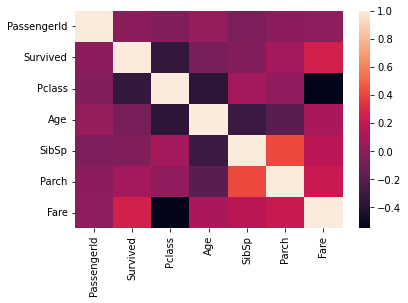

In [19]:
sns.heatmap(train_df.corr())

In [20]:
for place in train_df['Embarked'].unique()[0:3]:
    place_count = len(train_df[(train_df.Embarked == place)])
    a = len(train_df)
    print(f"Number of people from {place} are {place_count*100/a}%")

Number of people from S are 72.27833894500561%
Number of people from C are 18.855218855218855%
Number of people from Q are 8.641975308641975%


## Feature Engineering
---

In [21]:
# Merging Parent Children and Sibling Spouse to FamilyOnBoard
train_df['FamilyOnBoard']= train_df.SibSp + train_df.Parch
test_df['FamilyOnBoard']= test_df.SibSp + test_df.Parch

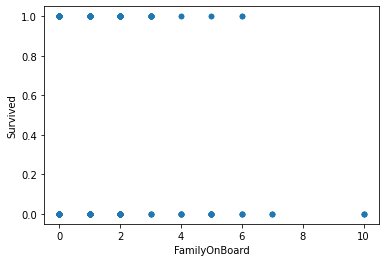

In [22]:
plot = train_df.plot.scatter('FamilyOnBoard','Survived')

In [23]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PassengerId    891 non-null    int64  
 1   Survived       891 non-null    int64  
 2   Pclass         891 non-null    int64  
 3   Name           891 non-null    object 
 4   Sex            891 non-null    object 
 5   Age            714 non-null    float64
 6   SibSp          891 non-null    int64  
 7   Parch          891 non-null    int64  
 8   Ticket         891 non-null    object 
 9   Fare           891 non-null    float64
 10  Cabin          204 non-null    object 
 11  Embarked       889 non-null    object 
 12  FamilyOnBoard  891 non-null    int64  
dtypes: float64(2), int64(6), object(5)
memory usage: 90.6+ KB
